<a href="https://colab.research.google.com/github/deepacefic/k-flip-MaxSAT/blob/main/k_flip_maxSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mini Project: A k-flip local search algorithm for MaxSAT**

____________________

*Deep Pooja*

##**Mini Project**
----------------------------------------------------------------------
Consider a propositional formula F in conjunctive normal form (CNF). Given a truth assignment τ to the variables of F, a k-flip is another assignment τ', which disagrees with τ on at most k variables. k-Flip Max SAT refers to the problem of deciding, given F, τ , and k, whether there exists a k-flip τ' which satisfies strictly more clauses of F than τ does (observe that the clauses satisfied by τ' is not necessarily a superset of the clauses satisfied by τ ). This problem is intractable.

Your task is to develop, implement, and test an algorithm 'A' that takes as input
a CNF formula F and an integer k. The algorithm first generates a random assign-
ment τ . Then it starts a loop where at each iteration it tries to increase the number of satisfied clauses using a k-flip. The algorithm terminates after a specified number of iterations or when a given timeout is reached. The k-flip improvements are found by solving k-Flip Max SAT utilizing an external (CDCL) SAT solver. Hence, 'A' employs the SAT solver as an oracle. We recommend using the Python toolkit PySAT to invoke the SAT solver.
'A' can be seen as a MaxSAT algorithm; we don’t expect it to be a very efficient
one, though. However, it is an interesting research question to analyse empirically how the improvement rate correlates with the value of k.
Implement and test algorithm 'A' with a basic prototype. Ideally, the prototype
should accept input CNF formulas in DIMACS format because there are many
benchmark instances available in that format.
Use your empirical results to analyze k’s influence on the speed of improvement
in terms of A’s the number of iterations. For this, run the algorithm with a few
choices of k ≤ 20. A secondary question is to compare the number of iterations with the actual run time including the time spent by the SAT solver.

**Sketch of the algorithm:**

The pseudocode is self-explanatory with proper comments.


```
Input: A CNF formula F and An integer k
Output: An assignmnet T with maximum satisfiability of F

1. num_vars<---F.nv //getting the largest variable in the formula
2. T<---random_pick(num_vars,{1,0}) //initial assignment
3. score<---nof_satisfied_clauses(F,T)
4. oracle<---Solve()  // initialize oracle

// first cardinality constraint encoding k-flips(atmost),
 that doest not change during each iteration since k is fixed

5. G'<---encode_k-flips(type=AtMost,bound = k) 
6. for i in G'.clauses:
7.     oracle.add_clause(i) // feed the clauses to the SAT oracle

// Now, start the loop. Note that the encoding of second cardinality constraint 
concerning no. of satisfied clauses will change in 
each iteration in order to maximize it.

8. for i <=iterations:
9.    G''<---encode_nof_satisfied-cls(type = AtLeast, bound = score)
10.    for i in G''.clauses:
11.       oracle.add_clauses(i) // feed it to the oracle
12.     is_SAT = oracle.solve()  // solving the SAT oracle
13.     if is_SAT == TRUE:
14.        m = oracle.get_model() //  extracting the satisfying assignment/model
15.        T' <--- func(m)       // new assignment(binary vector)
16.        count_scl<---nof_satisfied_clauses(F,T') // no.of
 satisfied clauses of the original formula F using new assignment T'
17.         score = count_scl  // increases the bound for the next iteration
18.     else:        // abort
19.     print("UnSAT at iteration",i)
20.     oracle.delete()
21.     break       
   

```





## Data used: 100 uniform random 3-SAT instances with 430 clauses.

## Implentaion using PySAT.

##Installing the PySAT library

In [ ]:
!pip install python-sat[pblib,aiger]

In [ ]:
#importing the requirments

from pysat.solvers import Solver
from pysat.formula import CNF
from pysat.card import *
import random
import numpy as np

"""
Reading the CNF formula from DIMACS file

"""
with open('/content/uf100-06.cnf', 'r+') as fp:
  f1 = CNF(from_fp=fp)  # reading from a file pointer

print(f1.clauses)
print(len(f1.clauses))

[[-21, -29, -89], [34, 88, 35], [67, -72, -26], [-93, 65, 16], [55, -5, 66], [23, -97, 42], [69, 21, -30], [9, 8, -24], [21, 39, -40], [74, 81, 66], [-52, 29, 39], [-36, 9, -48], [17, -21, 95], [-15, 75, 79], [15, -85, 80], [-76, -19, -61], [-5, -68, 34], [85, -100, -16], [-39, 29, 34], [-7, 24, 22], [-8, -22, -32], [-55, -96, 57], [10, -49, -36], [81, 11, -19], [-51, -9, 81], [85, -2, 50], [-6, 25, -37], [99, 23, 48], [23, 28, 32], [-99, -91, 43], [-8, -48, 39], [98, 68, 34], [-34, -29, 69], [2, 85, -43], [67, 25, 74], [-45, -11, 85], [92, -66, 15], [71, 34, 74], [-55, 17, 20], [-81, 16, -70], [-91, -70, -85], [22, -45, 18], [-82, -40, -51], [90, 34, 82], [54, -11, -47], [-97, 56, -41], [-33, -53, 38], [68, 71, 47], [-83, 15, -59], [95, 78, -100], [-13, -98, -20], [-46, -11, -4], [90, 28, -64], [62, -28, 4], [10, 86, 5], [-75, -40, -3], [45, 38, -91], [41, 11, 79], [-93, 10, 52], [23, 40, -29], [32, 24, -95], [14, 62, 24], [55, -50, 56], [57, 45, 12], [-51, -63, 81], [35, -21, -54], [

In [ ]:
num_vars = f1.nv #getting the largest identifier 

literals = list(range(1,num_vars+1)) # get the set of variables

# Randomly generating initial assignment

T = {} # dictionary to store the initial assignmnet whose keys are variables and values are 0 or 1
for i in range(1,num_vars+1):
        T[i] = np.random.randint(2) # initial assignment 


In [ ]:
"""
A function to compute the number of satisfying clauses given a CNF formula and an assignmnet 

"""
def nof_scl(formula, T):
  score = 0       # a varible to stores the number of satisying clauses:
  flag = 0
  for i,item in enumerate(formula):
    for j, it in enumerate(item):
      if it < 0:
        it = -it
        if T[it] == 0:
          flag = flag+1
      else:
        if T[it] == 1:
          flag = flag+1    
    if flag == 3:           # conjunctive clause (T): when all of the literals that form it are true
      score = score + 1
      flag = 0
  return score

In [ ]:
score = nof_scl(f1.clauses, T)  # number of clauses satisfied by the initial assignmnent
score 

2

In [ ]:
iterations = 1000 # number of iteration
nof_cl = []      # a list to store no. of satisfying clauses in each iteration
nof_cl.append(score) 

In [ ]:
k = 5 #the parameter k (choosen)

In [ ]:
oracle = Solver() # Inializing the SAT oracle without assumptions

In [ ]:
# first cardinality constraint encoding k-flips(atmost), doest not change during iteration

G1 = CardEnc.atmost(lits= literals, encoding=1, bound= k) 

# feed each clauses to the SAT oracle
for cl in G1.clauses:
  oracle.add_clause(cl)

In [ ]:
print(len(G1.clauses))

1040


Now, we need consider second cardinality constraint for number of satisfying clauses (atleat). That changes in each iteration

##**The Loop**

In [ ]:
T_p = {} # A dictionary for the new assignment 

for i in range(1,iterations+1):

  # second cardinality constraint encoding number of satisfying clauses(#atleat), changes during each iteration
  G2 = CardEnc.atleast(lits= literals, encoding=1, bound= score)

  #print(len(G2.clauses))

  # feed each clause of the G2 to the SAT oracle
  for cl in G2.clauses:
    oracle.add_clause(cl)

  is_sat = oracle.solve() # checking the satisfiability/solving the SAT

  print(is_sat)

  if is_sat:     # if True

    m = oracle.get_model()  # get the satisfying asignment (model)
    print(m)

    # computing the new assignmnet (binary vector) corresponding to the model
    for i in range(1,num_vars+1):
      if m[i]>0:
        T_p[i] = 1
      else:
        T_p[i] = 0

    #calculating the number of satisfied clauses in the original formula F for the new assignment
    sl = nof_scl(f1.clauses,T_p)

    #adding it to the list
    nof_cl.append(sl)

    #updating the number of satisfied clauses for the second cardinality constraint encoding in next iteration
    score = sl

  else:    # if USAT abort
    print("USAT at iteration ",i)
    oracle.delete()
    break

False
USAT at iteration  1


In [ ]:
nof_cl

[1, 2]

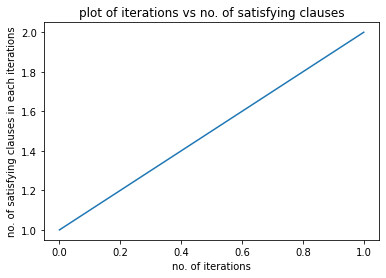

In [ ]:
import matplotlib.pyplot as plt

plt.plot(nof_cl)
  
plt.xlabel('no. of iterations')

plt.ylabel('no. of satisfying clauses in each iterations')
  

plt.title('plot of iterations vs no. of satisfying clauses')
  
plt.show()

##**TODO:**

2. Analyze the effect of the parameter k on the number of iterations.
3. Compare the no. of iterations with actual run time (including the time for SAT-solver).
